# ESTIMATIVA DE BIOMASSA FLORESTAL USANDO DADOS LIDAR

**SER-347**  Introdução à Programação para Sensoriamento Remoto

**Nome:** Luciane Yumie Sato
<p style="font-size:60%;">
**Contato:** lucianesato@gmail.com
</p>

<img src=".\Figuras\lidar.png">

# Introdução:
<p style="font-size:60%;">
Esse roteiro é parte do trabalho desenvolvido para a disciplina de Introdução à Programação para Sensoriamento Remoto (SER-347) do Instituto Nacional de Pesquisas Espaciais (INPE).
</p>

<p style="font-size:60%;">
As amostras de dados LiDAR (Light Detection and Ranging) são parte do projeto **Monitoramento Ambiental por Satélite no Bioma Amazônia (MSA)**, do subprojeto Melhoria dos Métodos de Estimativa de Biomassa e de Modelos de Estimativa de Emissões por Mudança de Uso da Terra. Para maiores informações do projeto acesse o site do projeto http://www.ccst.inpe.br/projetos/eba-estimativa-de-biomassa-na-amazonia/.
</p>

<p style="font-size:60%;">
No total o projeto coletou 1.000 transectos LiDAR. Para facilitar o processamento, essa rotina permite que vários arquivos LiDAR sejam processados sem a necessidade de realizar as etapas de processamento arquivo por arquivo.
</p>

<p style="font-size:60%;">
Para o processamento dos dados LiDAR é utilizado o programa LASTools, que é um software específico para processamento de dados LiDAR. 
</p>

<p style="font-size:90%;">
O principal **objetivo** desse trabalho é estimar a biomassa florestal a partir de dados coletados com o instrumento LiDAR. Além disso, com o desenvolvimento desse trabalho, buscou-se automatizar o processo de cálculo da estimativa da biomassa florestal.
</p>

# Resumo Metodologia:

![caption](Figuras/metodologia_biomassa.png)

## **1. Carregar as bibliotecas**

In [2]:
from osgeo import gdal, ogr
import geopandas as gpd

## 2. Criação do 1 $^{\circ}$ conjuto de dados LiDAR (originais)

O software LASTools permite processar uma lista de arquivo (file_list) que indica o caminho dos arquivos que serão processados. A criação do arquivo file_list facilita o processamento de vários arquivos e, com irro, não é necessário processar um arquivo de cada vez.

In [2]:
import os

#Diretório com os arquivos LiDAR (originais)
dir = "C:\\ser347\\data\\laz"

#Criando o arquivo file_list com os arquivos no diretório definido.
file_list_laz = os.path.join(dir,"file_list.txt")

f = open(file_list_laz, 'w')

#Para os arquivos do diretório (dir) que termine com .las e comece com "NP_T_", cria o file_list:
for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\data\laz\NP_T_0066.laz
C:\ser347\data\laz\NP_T_0067.laz
C:\ser347\data\laz\NP_T_0068.laz
C:\ser347\data\laz\NP_T_0069.laz
C:\ser347\data\laz\NP_T_0070.laz


## 3. Lasnoise

**Função:** Remover o ruído dos dados LiDAR. 



## Parâmetros:
- **lof**: indica que todos os arquivos do file_liest sserão processados.
- **step_xy**: informa que as unidades de medida estão em metros.
- **remove_noise**: remove os ruídos.
- **odir**: especifica o diretório de saída.
- **olaz**: especifica o formato do arquivo de saída.

In [1]:
from subprocess import PIPE, run

lasnoise = ["C:\\LAStools\\bin\\lasnoise.exe","-lof", "C:\\ser347\\data\\laz\\file_list.txt",
            "-step_xy", "4", "-step_z", "1", "-remove_noise", "-odir", 
            "C:\\ser347\\lasnoise", "-olaz"]
removenoise = run(lasnoise, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(removenoise.returncode, removenoise.stdout, removenoise.stderr)

0  done with 'C:\ser347\lasnoise\NP_T_0066.laz'. took 101.584 sec. found 125447 noise points.
done with 'C:\ser347\lasnoise\NP_T_0067.laz'. took 197.968 sec. found 85563 noise points.
done with 'C:\ser347\lasnoise\NP_T_0068.laz'. took 292.951 sec. found 42781 noise points.
done with 'C:\ser347\lasnoise\NP_T_0069.laz'. took 390.546 sec. found 66803 noise points.
done with 'C:\ser347\lasnoise\NP_T_0070.laz'. took 500.111 sec. found 46598 noise points.



## 3. Lasnoise

<img src=".\Figuras\lidar_original1.png" width = "100%">

## 3. Lasnoise

<img src=".\Figuras\lasnoise.png" width = "100%">

## 4. Criação do 2$^{\circ}$ conjuto de dados LiDAR (sem ruído)

In [4]:
#Diretório com os arquivos LiDAR (sem ruído)
dir = "C:\\ser347\\lasnoise"

#Criando o arquivo file_list com os arquivos no diretório definido.
file_list_lasnoise = os.path.join(dir,"file_list.txt")

f = open(file_list_lasnoise, 'w')

#Para os arquivos do diretório (dir) que termine com .las e comece com "NP_T_", cria o file_list:
for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\lasnoise\NP_T_0066.laz
C:\ser347\lasnoise\NP_T_0067.laz
C:\ser347\lasnoise\NP_T_0067_1.laz
C:\ser347\lasnoise\NP_T_0068.laz
C:\ser347\lasnoise\NP_T_0069.laz
C:\ser347\lasnoise\NP_T_0070.laz


## 5. Lasground

**Função:** Gerar o modelo de elevação do terreno. Essa etapa é necessária para a etapa das alturas das árvores e, posteriomente, para a obtenção da biomassa florestal. 

A altura das árvores é obtida através da subtração entre o os pontos do topo do Dossel e os pontos do terreno.

A Figura apresentada abaixo ilustra o processo para a obtenção da altura das árvores. 

<img src="./Figuras/subtracao.png" width = "80%">

## Parâmetros:
- **cores**: processa os arquivos usando multiplos cores.
- **drop_classifiction**: filtra os pontos de acordo com a sua classificação.
- **nature**: usado para terrenos sem construções.

In [6]:
lasground = ["C:\\LAStools\\bin\\lasground_new.exe","-lof", "C:\\ser347\\lasnoise\\file_list.txt",
            "-cores","4","-drop_classification","7","-nature","-odir","C:\\ser347\\lasground","-olaz"]

ground = run(lasground, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(ground.returncode, ground.stdout, ground.stderr)

0  done with 'C:\ser347\lasground\NP_T_0068.laz'. total time 1737.82 sec.
done with 'C:\ser347\lasground\NP_T_0066.laz'. total time 1790.4 sec.
done with 'C:\ser347\lasground\NP_T_0067.laz'. total time 1807.05 sec.
done with 'C:\ser347\lasground\NP_T_0069.laz'. total time 2003.32 sec.
done with 'C:\ser347\lasground\NP_T_0070.laz'. total time 996.686 sec.



## 5. Lasground

<img src="./Figuras/lasground1.png" width = "80%">

## 6. Criação do 3$^{\circ}$ conjuto de dados LiDAR

In [7]:
dir = "C:\\ser347\\lasground"

file_list_lasground = os.path.join(dir,"file_list.txt")

f = open(file_list_lasground, 'w')

for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\lasground\NP_T_0066.laz
C:\ser347\lasground\NP_T_0067.laz
C:\ser347\lasground\NP_T_0068.laz
C:\ser347\lasground\NP_T_0069.laz
C:\ser347\lasground\NP_T_0070.laz


## 7. Lasheight
**Função:** Gerar o modelo de altura. Essa etapa é necessária para obtenção da biomassa. A biomassa florestal é gerada a partir da regreção com modelo de altura.


## Parâmetros:
- **replace_z**: normaliza a altura dos pontos de acordo com a referência no terreno.
- **drop_above**: elina os pontos com uma altura determinada.

In [8]:
lasheight = ["C:\\LAStools\\bin\\lasheight.exe","-lof", "C:\\ser347\\lasground\\file_list.txt",
            "-cores","4","-replace_z","-drop_below","0.01","-drop_above","40","-odir",
             "C:\\ser347\\lasheight","-olaz"]

height = run(lasheight, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(height.returncode, height.stdout, height.stderr)


0  done with 'C:\ser347\lasheight\NP_T_0066.laz'. total time 255.876 sec.
done with 'C:\ser347\lasheight\NP_T_0069.laz'. total time 269.512 sec.
done with 'C:\ser347\lasheight\NP_T_0067.laz'. total time 271.525 sec.
done with 'C:\ser347\lasheight\NP_T_0068.laz'. total time 283.255 sec.
done with 'C:\ser347\lasheight\NP_T_0070.laz'. total time 149.071 sec.



## 7. Lasheight

<img src="./Figuras/lasheight.png" width = "80%">

## 8. Criação do 4$^{\circ}$ conjuto de dados LiDAR gerados pelo Lasheight

In [9]:
dir = "C:\\ser347\\lasheight"

file_list_lasheight = os.path.join(dir,"file_list.txt")

f = open(file_list_lasheight, 'w')

for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\lasheight\NP_T_0066.laz
C:\ser347\lasheight\NP_T_0067.laz
C:\ser347\lasheight\NP_T_0068.laz
C:\ser347\lasheight\NP_T_0069.laz
C:\ser347\lasheight\NP_T_0070.laz


## 9. Lasclassify
**Função**: Classificar os pontos de terreno e vegetação.

In [10]:
#Classificar os pontos - Lasclassify

from subprocess import PIPE, run

lasclassify = ["C:\\LAStools\\bin\\lasclassify.exe","-lof", "C:\\ser347\\lasheight\\file_list.txt","-cores","4","-odir",
             "C:\\ser347\\lasclassify1","-olaz"]

classify1 = run(lasclassify, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(classify1.returncode, classify1.stdout, classify1.stderr)

0  done with 'C:\ser347\lasclassify1\NP_T_0066.laz'. total time 682.974 sec.
done with 'C:\ser347\lasclassify1\NP_T_0069.laz'. total time 700.495 sec.
done with 'C:\ser347\lasclassify1\NP_T_0067.laz'. total time 721.204 sec.
done with 'C:\ser347\lasclassify1\NP_T_0068.laz'. total time 738.545 sec.
done with 'C:\ser347\lasclassify1\NP_T_0070.laz'. total time 347.835 sec.



## 10. Criação do 5$^{\circ}$  conjuto de dados LiDAR gerados pelo Lasclassify

In [11]:
#Criando a lista qde arquivos lasground que serão processados. Facilita o processamento de vários arquivos.

dir = "C:\\ser347\\lasclassify1"

file_list_lasheight = os.path.join(dir,"file_list.txt")

f = open(file_list_lasheight, 'w')

for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\lasclassify1\NP_T_0066.laz
C:\ser347\lasclassify1\NP_T_0067.laz
C:\ser347\lasclassify1\NP_T_0068.laz
C:\ser347\lasclassify1\NP_T_0069.laz
C:\ser347\lasclassify1\NP_T_0070.laz


### 9.1. Lasclassify
**Função:** Classificar os pontos de terreno e vegetação. As vezes é necessário classificar os pontos mais de uma vez, pois nem todos os pontos são classificados na primeira classificação.

In [12]:
#Segunda classificação - Lasclassify

lasclassify2 = ["C:\\LAStools\\bin\\lasclassify.exe","-lof", "C:\\ser347\\lasclassify1\\file_list.txt",
               "-cores","4", "-change_classification_from_to","1","5","-change_classification_from_to","6","5",
               "-odir","C:\\ser347\\lasclassify2","-olaz"]

classify2 = run(lasclassify2, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(classify2.returncode, classify2.stdout, classify2.stderr)

0  done with 'C:\ser347\lasclassify2\NP_T_0066.laz'. total time 720.242 sec.
done with 'C:\ser347\lasclassify2\NP_T_0069.laz'. total time 740.651 sec.
done with 'C:\ser347\lasclassify2\NP_T_0067.laz'. total time 764.531 sec.
done with 'C:\ser347\lasclassify2\NP_T_0068.laz'. total time 784.557 sec.
done with 'C:\ser347\lasclassify2\NP_T_0070.laz'. total time 390.912 sec.



## 11. Criação do 6$^o$  conjuto de dados LiDAR gerados pelo Lasclassify

In [16]:
#Criando a lista qde arquivos lasground que serão processados. Facilita o processamento de vários arquivos.

dir = "C:\\ser347\\lasclassify2"

file_list_lasheight = os.path.join(dir,"file_list.txt")

f = open(file_list_lasheight, 'w')

for file in os.listdir(dir):
    if file.endswith(".laz") and file.startswith("NP_T_"):
        print(os.path.join(dir, file))
        f.write("{}\n".format(os.path.join(dir, file)))
f.close()

C:\ser347\lasclassify2\NP_T_0066.laz
C:\ser347\lasclassify2\NP_T_0067.laz
C:\ser347\lasclassify2\NP_T_0068.laz
C:\ser347\lasclassify2\NP_T_0069.laz
C:\ser347\lasclassify2\NP_T_0070.laz


## 12. Lasgrid
**Função:** Gerar uma grade com os valores de altura das árvores.

In [27]:
lasgrid = ["C:\\LAStools\\bin\\lasgrid.exe","-lof", "C:\\ser347\\lasclassify2\\file_list.txt",
          "-cores","4","-elevation","-highest","-subcircle","0.2","-fill","20","-odir","C:\\ser347\\lasgrid","-oasc"]

gridtile = run(lasgrid, stdout=PIPE, stderr=PIPE, universal_newlines=True)
print(gridtile.returncode, gridtile.stdout, gridtile.stderr)

0  


## 12. Lasgrid

<img src="./Figuras/lasgrid.png" width = "50%">


## 13. Reprojetar os dados

Após o processamento do software LASTolls, os arquivos das imagens LiDAR perdem a referência espacial. Por isso, é necesário reprojetar os dados.

Será apresentada uma forma de reprojetar os dados, mas essa etapa pode ser feita de outras formas.

### 13.1. Copiando os arquivos .prj dos dados LiDAR (originais) para a pasta dos arquivos de altura (lasgrid).

In [11]:
import os
import shutil
os.chdir('C:\\') #Make sure you add your source and destination path below

dir_src = ("C:\\ser347\\data\\shp\\")
dir_dst = ("C:\\ser347\\lasgrid")

for filename in os.listdir(dir_src):
    if filename.endswith('.prj'):
        shutil.copy( dir_src + filename, dir_dst)
        print(filename)

POLIGONO_T_0066.prj
POLIGONO_T_0067.prj
POLIGONO_T_0068.prj
POLIGONO_T_0069.prj
POLIGONO_T_0070.prj


### 13.2 Renomear os arquivos .prj para o mesmo nome dos dados de altura.

In [12]:
os.chdir('C:\\')

dir_dst = ("C:\\ser347\\lasgrid")

for file_name in os.listdir(dir_dst):
    if file_name.endswith('.prj') and file_name.startswith("POLIGONO_T"):
        full_file_name = os.path.join(dir_dst, file_name)
        os.rename(full_file_name, full_file_name.replace("POLIGONO_T", "NP_T_"))
        print(full_file_name)

C:\ser347\lasgrid\POLIGONO_T_0066.prj
C:\ser347\lasgrid\POLIGONO_T_0067.prj
C:\ser347\lasgrid\POLIGONO_T_0068.prj
C:\ser347\lasgrid\POLIGONO_T_0069.prj
C:\ser347\lasgrid\POLIGONO_T_0070.prj


## 14. Cálculo da Biomassa Florestal

Após o processamento dos dados LiDAR, é aplicada a equação de Longo et al. (2016) para obter os valores de biomassa para cada 
transectos LiDAR.

**Equação: biomassa = $2*0.052*(Altura LiDAR**1.77)$**

Nessa etapa são realizadas as seguintes tarefas para cada arquivo LiDAR:

- Abrir o arquivo .asc
- Ler o arquivos .asc como um array
- Define os valores -9999 como noDATA
- Aplicar a equação de Longo et al. (2016)

In [4]:
#img = gdal.Open("C:\\ser347\\T_0066\\merger_grid_teste.asc")
import numpy as np
import os
import shutil
import scipy.linalg
os.chdir('C:\\')

dir_dst = ("C:\\ser347\\lasgrid")

for transecto_file in os.listdir(dir_dst):
    if transecto_file.endswith('.asc'):
        transecto = gdal.Open(os.path.join(dir_dst, transecto_file))
        print(transecto)
        transecto_array = transecto.ReadAsArray()
        transecto_array[transecto_array==-9999]=np.nan
        biomassa = 2*0.052*(transecto_array**1.77)
        width = len(biomassa[0])
        height = len(biomassa)
        drive = gdal.GetDriverByName("GTiff")
        nome = "AGB_"+transecto_file[0:-3]+"tif"
        arquivo_saida = os.path.join("C:\\ser347\\AGB\\", nome)
        print(arquivo_saida)
        data_source = drive.Create(arquivo_saida, width, height, 1, gdal.GDT_Float32)
        trans= transecto.GetGeoTransform()
        proj = transecto.GetProjection()
        data_source.SetGeoTransform(trans)
        data_source.SetProjection(proj)
        data_source.GetRasterBand(1).SetNoDataValue(np.nan)
        data_source.GetRasterBand(1).WriteArray(biomassa)
        data_source.FlushCache()
        del data_source


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021BF9DCD2A0> >
C:\ser347\AGB\AGB_NP_T_0066.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021BF9AD44B0> >
C:\ser347\AGB\AGB_NP_T_0067.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021BF9DCD2A0> >
C:\ser347\AGB\AGB_NP_T_0068.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021BF9AD44B0> >
C:\ser347\AGB\AGB_NP_T_0069.tif
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000021BF9DCD2A0> >
C:\ser347\AGB\AGB_NP_T_0070.tif


## 15. Plotar a biomassa florestal do transecto LiDAR

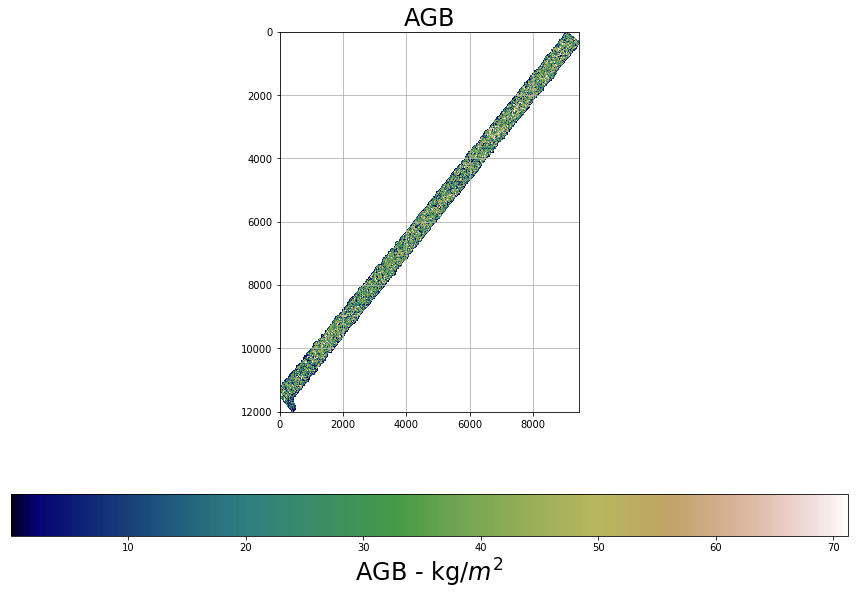

In [6]:
import matplotlib.pyplot as plt

biomassa = gdal.Open("C:\ser347\AGB\AGB_NP_T_0066.tif")
biomassa_array = biomassa.ReadAsArray()

# Plot PRISM array again
fig, ax = plt.subplots(figsize=[15, 10])
ax.set_title('AGB', fontsize=24)
 
# Get the img object in order to pass it to the colorbar function
img_plot = ax.imshow(biomassa_array, cmap='gist_earth') #jet

cbar = plt.colorbar(img_plot, orientation='horizontal')
cbar.set_label('AGB - kg/$m^2$', fontsize=24)

 
ax.grid(True)
plt.show()

## 15. Histograma da biomassa florestal do transecto LiDAR

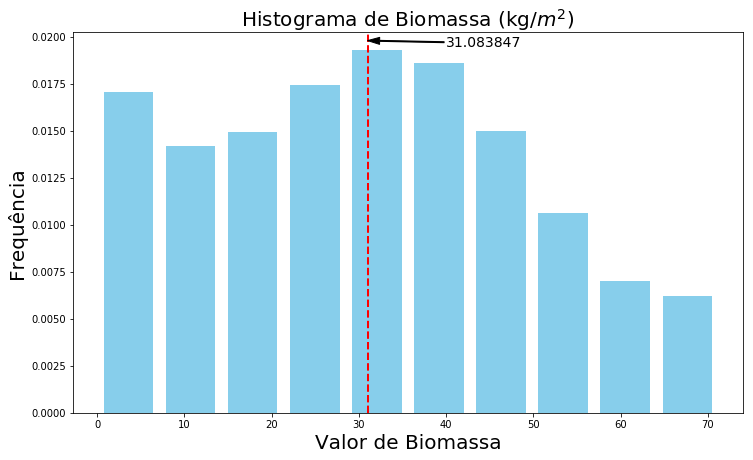

In [119]:
fig, ax = plt.subplots(figsize=[12, 7])
ax.set_title('AGB', fontsize=24)

plt.hist(biomassa_array_nn, density=True,rwidth=.8, color = "skyblue")
plt.title("Histograma de Biomassa (kg/$m^2$)", fontsize=20)
plt.xlabel("Valor de Biomassa", fontsize=20)
plt.ylabel("Frequência", fontsize=20)

plt.axvline(biomassa_array_nn.mean(), color='red', linestyle='dashed', linewidth=2)
#plt.text(30, .02, r'$\mu=100,\ \sigma=15$')
plt.annotate(biomassa_array_nn.mean(), xy=(31,0.0198), xytext =(40,0.0195),
             arrowprops = dict(facecolor="black",shrink = 0, width = 1, headwidth = 7), 
            fontsize = 14);
